In [1]:
from utils.alloys import alloy_to_1d_tensor
from utils.constants import alloy_max_len, n_elements
from utils.ml import *
from utils.dataframes import dfs_tabs
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split

2023-09-11 15:11:46.345881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 15:11:46.895021: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-11 15:11:47.976784: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/include:/usr/local/cuda-11.0/lib64:
2023-09-11 15:11:47.976892: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerro

In [2]:
df_train = pd.read_csv("train_final_df.csv")
df_test = pd.read_csv("test_final_df.csv")

# Print the shape of the training and testing sets to check the split sizes
print("Training set shape:", df_train.shape)
print("Testing set shape:", df_test.shape)

Training set shape: (1269, 3)
Testing set shape: (318, 3)


In [3]:
# constants
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ideally a max factor is from the training dataset
max_factor = max(df_train["actual_d_max"])
print(max_factor)

35.0


In [5]:
print(alloy_to_1d_tensor(df_train.loc[0, "bmg_alloy"]), df_train.loc[0, "bmg_alloy"]) 

tensor([ 5.,  6., 24., 16., 26., 78.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.]) B6.0Cr16.0Fe78.0


In [4]:
# creating the input and output data for the model
X_train = []
y_train = []

X_test = []
y_test = []

for i in range(df_train.shape[0]):
    X_train.append(alloy_to_1d_tensor(df_train.loc[i, "bmg_alloy"]))
    y_train.append(df_train.loc[i, "actual_d_max"] / max_factor)

X_train = torch.stack(X_train)
y_train = torch.tensor(y_train, dtype=torch.float32)

print(X_train.shape, X_train.dtype, y_train.shape, min(y_train).item(), max(y_train).item())

torch.Size([1269, 20]) torch.float32 torch.Size([1269]) 0.0 1.0


In [5]:
for i in range(df_test.shape[0]):
    X_test.append(alloy_to_1d_tensor(df_test.loc[i, "bmg_alloy"]))
    y_test.append(df_test.loc[i, "actual_d_max"] / max_factor)
    
# max_factor we selected is fine
X_test = torch.stack(X_test)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(X_test.shape, min(y_test).item(), max(y_test).item())

torch.Size([318, 20]) 0.0 0.8571428656578064


In [6]:
import torch
from torch import nn

class SequenceToSigmoid(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [7]:
# Bidirectional LSTM
# Define hyperparameters
input_size = 20
hidden_size = 128
learning_rate = 0.001
num_epochs = 5000
batch_size = 32
num_layers = 10

# Create an instance of the model
model = SequenceToSigmoid(input_size, hidden_size, num_layers)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)

# Create a PyTorch DataLoader for batching the data
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Set the device to use (CPU or GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print_every = 100
plot_loss = []
# TODO: print the average loss
# EDIT: we are printing epoch loss of batch

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Iterate over the batches of data
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate the loss
        # print("output", outputs.squeeze(), "\nlabel", labels)
        loss = criterion(outputs.squeeze(), labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update the running loss
        running_loss += loss.item()
    
    # Calculate the average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    
    # Print the loss for this epoch
    if epoch % print_every == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    plot_loss.append(epoch_loss)

Epoch 1/5000, Loss: 0.3460
Epoch 101/5000, Loss: 0.2375
Epoch 201/5000, Loss: 0.2341
Epoch 301/5000, Loss: 0.2327
Epoch 401/5000, Loss: 0.2327
Epoch 501/5000, Loss: 0.2323
Epoch 601/5000, Loss: 0.2311
Epoch 701/5000, Loss: 0.2295
Epoch 801/5000, Loss: 0.2294
Epoch 901/5000, Loss: 0.2299
Epoch 1001/5000, Loss: 0.2329
Epoch 1101/5000, Loss: 0.2287
Epoch 1201/5000, Loss: 0.2284
Epoch 1301/5000, Loss: 0.2286
Epoch 1401/5000, Loss: 0.2283
Epoch 1501/5000, Loss: 0.2300
Epoch 1601/5000, Loss: 0.2286
Epoch 1701/5000, Loss: 0.2280
Epoch 1801/5000, Loss: 0.2289
Epoch 1901/5000, Loss: 0.2294
Epoch 2001/5000, Loss: 0.2284
Epoch 2101/5000, Loss: 0.2296
Epoch 2201/5000, Loss: 0.2281
Epoch 2301/5000, Loss: 0.2304
Epoch 2401/5000, Loss: 0.2283
Epoch 2501/5000, Loss: 0.2287
Epoch 2601/5000, Loss: 0.2283
Epoch 2701/5000, Loss: 0.2283
Epoch 2801/5000, Loss: 0.2281
Epoch 2901/5000, Loss: 0.2299
Epoch 3001/5000, Loss: 0.2297
Epoch 3101/5000, Loss: 0.2304
Epoch 3201/5000, Loss: 0.2281
Epoch 3301/5000, Loss:

Text(0, 0.5, 'Loss')

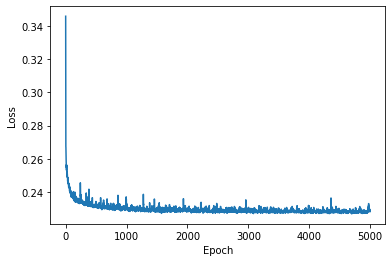

In [8]:
plt.plot(range(len(plot_loss)), plot_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [9]:
# Assuming you have a separate validation dataset X_val and y_val

# Set the model in evaluation mode
model.eval()

# Convert the validation data to PyTorch tensors
X_val_tensor = torch.Tensor(X_test)
y_val_tensor = torch.Tensor(y_test)

# Create a PyTorch DataLoader for batching the validation data
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

predicted_labels = []
true_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Append the predicted and true labels to the lists
        predicted_labels.extend(outputs.squeeze())
        true_labels.extend(labels)

In [10]:
r2 = r2_score(np.array(true_labels)*max_factor, np.array(predicted_labels)*max_factor)
print(f"R2 Score: {r2:.4f}")

R2 Score: 0.8186


<AxesSubplot:>

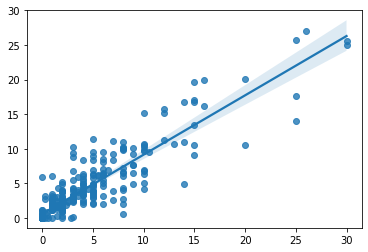

In [11]:
sns.regplot(x=np.array(true_labels)*max_factor, y=np.array(predicted_labels)*max_factor)

In [12]:
torch.save(model.state_dict(), "rnn_trainset_trained_method_1.pt")

## 2. Predict d_max and create a new dataset (dataset_rnn) to train another model on

In this step we use the RNN models predictions to add a new feature to our current dataset and see if the predictions can be improved.

In [13]:
all_rnn_train_output = []
for i in range(df_train.shape[0]):
        alloy_tensor = alloy_to_1d_tensor(df_train.loc[i, "bmg_alloy"])
        output = model(torch.atleast_2d(alloy_tensor))
        all_rnn_train_output.append(output.squeeze().item() * max_factor)

all_rnn_test_output = []
for i in range(df_test.shape[0]):
    alloy_tensor = alloy_to_1d_tensor(df_test.loc[i, "bmg_alloy"])
    output = model(torch.atleast_2d(alloy_tensor))
    all_rnn_test_output.append(output.squeeze().item() * max_factor)
    
new_train = df_train
new_test = df_test

new_train["rnn_encoding"] = all_rnn_train_output
new_test["rnn_encoding"] = all_rnn_test_output

dfs = [new_train, new_test]
sheets = ["train", "test"]
dfs_tabs(dfs, sheets, 'dataset_rnn.xlsx')

In [14]:
df_train = pd.read_excel("dataset_rnn.xlsx", sheet_name="train")
df_test = pd.read_excel("dataset_rnn.xlsx", sheet_name="test")
display(df_train)
display(df_test)

,bmg_alloy,paper_sno,actual_d_max,rnn_encoding
0,B6.0Cr16.0Fe78.0,[9],0.00,0.00
1,B22.3Fe66.9Mo3.72Dy7.0,[9],2.00,2.04
2,Mg11.0Ca55.0Cu23.0Zn11.0,"[5, 7]",1.00,1.17
3,Mg84.5Mn8.0Y7.5,[9],0.00,0.00
4,Al95.0Co3.0Ce2.0,[9],0.00,0.00
...,...,...,...,...
1264,Cu55.0Ga5.0Zr40.0,"[9, 5, 7]",2.00,1.90
1265,B20.0Si4.0Fe71.2Cu0.8Nb4.0,[2],1.00,1.13
1266,Mg25.0Ca55.0Zn20.0,"[9, 5, 7]",1.00,1.95
1267,B6.0C15.0Cr4.0Mn10.0Fe53.0Mo12.0,[2],3.00,2.98


,bmg_alloy,paper_sno,actual_d_max,rnn_encoding
0,Ni50.0Cu40.0Hf10.0,[9],0.00,0.00
1,Al8.0Cu36.0Zr46.0Pd2.0Ag8.0,"[1, 6]",30.00,25.88
2,Al25.0Co20.0Tm55.0,"[5, 7]",3.00,3.86
3,B4.0C4.0Si2.0P10.0Fe75.0Ga3.0Mo2.0,"[1, 2, 5, 6, 9]",2.50,2.46
4,Al2.0Cu90.0Ce8.0,[9],0.00,0.00
...,...,...,...,...
313,B2.0Fe86.0Mo12.0,[9],0.00,0.00
314,Fe42.0Cu41.0Ag17.0,[9],0.00,0.00
315,Be23.0Ti24.0Fe6.0Ni10.0Cu9.0Zr28.0,"[1, 6]",4.00,6.03
316,Mg22.5Ca50.0Cu27.5,"[9, 5, 7]",10.00,6.67


In [15]:
df_train = pd.read_excel("dataset_rnn.xlsx", index_col=0, sheet_name="train")
df_test = pd.read_excel("dataset_rnn.xlsx", index_col=0, sheet_name="test")
# df_test = df_test.drop(["predicted_d_max"], axis=1)
df_train = df_train.drop(["paper_sno"], axis=1)
df_test = df_test.drop(["paper_sno"], axis=1)
X_train, y_train = df_train.loc[:, df_train.columns != "actual_d_max"], pd.DataFrame(df_train["actual_d_max"])
X_test, y_test = df_test.loc[:, df_test.columns != "actual_d_max"], pd.DataFrame(df_test["actual_d_max"])

R2 = []
ADJR2 = []
RMSE = []
names = []
TIME = []

for name, model in tqdm(REGRESSORS):
    start = time.time()
    pipe = Pipeline(steps=[
                        ("classifier", model()),
                    ]
                )
    try:
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        r_squared = r2_score(y_test, y_pred)
        print(name, r_squared)
        adj_rsquared = adjusted_rsquared(
            r_squared, X_test.shape[0], X_test.shape[1]
        )
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        names.append(name)
        R2.append(r_squared)
        ADJR2.append(adj_rsquared)
        RMSE.append(rmse)
        TIME.append(time.time() - start)
    except Exception as exception:
        print(name + " model failed to execute")
        print(exception)
    scores = {
                "Model": names,
                "Adjusted R-Squared": ADJR2,
                "R-Squared": R2,
                "RMSE": RMSE,
                "Time Taken": TIME,
            }
    scores = pd.DataFrame(scores)
    scores = scores.sort_values(by = "Adjusted R-Squared", ascending = False).set_index("Model")

 17%|██████████████                                                                      | 7/42 [00:00<00:00, 56.76it/s]

AdaBoostRegressor 0.821459792590402
BaggingRegressor 0.8204228464624705
BayesianRidge 0.8222080518643845
DecisionTreeRegressor 0.8142225285876525
DummyRegressor -0.005335325313598593
ElasticNet 0.824856317344346
ElasticNetCV 0.8224096710477933
ExtraTreeRegressor 0.8163317112588181
ExtraTreesRegressor 0.8179194688282643
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor -137.24348923432171
GradientBoostingRegressor 0.8194383430708432


 43%|███████████████████████████████████▌                                               | 18/42 [00:00<00:00, 25.02it/s]

HistGradientBoostingRegressor 0.8307553874706503
HuberRegressor 0.8225533907000402
KNeighborsRegressor 0.8268126834225309
KernelRidge 0.8224429300022211
Lars 0.8222069155801138
LarsCV 0.8222069155801138
Lasso 0.8248801539803867
LassoCV 0.8223094023418063
LassoLars 0.8248801539803867
LassoLarsCV 0.8222069155801138
LassoLarsIC 0.8222069155801138
LinearRegression 0.8222069155801138


 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:00<00:00, 33.60it/s]

LinearSVR 0.8219268208076022


 71%|███████████████████████████████████████████████████████████▎                       | 30/42 [00:01<00:00, 19.01it/s]

MLPRegressor 0.8224776804039402
NuSVR 0.8231763119487268
OrthogonalMatchingPursuit 0.8222069155801138
OrthogonalMatchingPursuitCV model failed to execute
Found array with 1 feature(s) (shape=(1269, 1)) while a minimum of 2 is required by OrthogonalMatchingPursuitCV.
PassiveAggressiveRegressor 0.33531110126340036
PoissonRegressor 0.6823565862968748
RANSACRegressor 0.8226652598970193


 81%|███████████████████████████████████████████████████████████████████▏               | 34/42 [00:01<00:00, 21.16it/s]

RandomForestRegressor 0.821381594345003
Ridge 0.8222102447168709
RidgeCV 0.8222072485561409
SGDRegressor 0.8220397210760705
SVR 0.8231428341248335
TransformedTargetRegressor 0.8222069155801138
TweedieRegressor 0.8248321136809477


 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:01<00:00, 19.79it/s]

XGBRegressor 0.8160212771513814
LGBMRegressor 0.8146266214376914
Learning rate set to 0.042513
0:	learn: 4.7866307	total: 54.1ms	remaining: 54s
1:	learn: 4.6095133	total: 54.8ms	remaining: 27.3s
2:	learn: 4.4396045	total: 55.4ms	remaining: 18.4s
3:	learn: 4.2739851	total: 56ms	remaining: 13.9s
4:	learn: 4.1145398	total: 56.6ms	remaining: 11.3s
5:	learn: 3.9650793	total: 57.2ms	remaining: 9.48s
6:	learn: 3.8264611	total: 57.8ms	remaining: 8.2s
7:	learn: 3.6876375	total: 58.4ms	remaining: 7.24s
8:	learn: 3.5584976	total: 59ms	remaining: 6.49s
9:	learn: 3.4315438	total: 59.5ms	remaining: 5.89s
10:	learn: 3.3114254	total: 60.1ms	remaining: 5.41s
11:	learn: 3.1982083	total: 60.6ms	remaining: 4.99s
12:	learn: 3.0850364	total: 61.2ms	remaining: 4.64s
13:	learn: 2.9759720	total: 61.7ms	remaining: 4.35s
14:	learn: 2.8720898	total: 62.2ms	remaining: 4.09s
15:	learn: 2.7760726	total: 62.7ms	remaining: 3.86s
16:	learn: 2.6823869	total: 63.3ms	remaining: 3.66s
17:	learn: 2.5875622	total: 63.9ms	rem

495:	learn: 0.5719733	total: 289ms	remaining: 294ms
496:	learn: 0.5719453	total: 290ms	remaining: 294ms
497:	learn: 0.5719329	total: 291ms	remaining: 293ms
498:	learn: 0.5718821	total: 291ms	remaining: 292ms
499:	learn: 0.5718413	total: 292ms	remaining: 292ms
500:	learn: 0.5717926	total: 292ms	remaining: 291ms
501:	learn: 0.5717831	total: 293ms	remaining: 290ms
502:	learn: 0.5717571	total: 293ms	remaining: 290ms
503:	learn: 0.5717181	total: 294ms	remaining: 289ms
504:	learn: 0.5716756	total: 295ms	remaining: 289ms
505:	learn: 0.5716387	total: 295ms	remaining: 288ms
506:	learn: 0.5716032	total: 296ms	remaining: 288ms
507:	learn: 0.5715812	total: 296ms	remaining: 287ms
508:	learn: 0.5715714	total: 297ms	remaining: 286ms
509:	learn: 0.5715333	total: 297ms	remaining: 286ms
510:	learn: 0.5715081	total: 298ms	remaining: 285ms
511:	learn: 0.5714746	total: 298ms	remaining: 284ms
512:	learn: 0.5714294	total: 300ms	remaining: 284ms
513:	learn: 0.5714207	total: 300ms	remaining: 284ms
514:	learn: 

100%|███████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 16.60it/s]

861:	learn: 0.5665851	total: 475ms	remaining: 76ms
862:	learn: 0.5665719	total: 476ms	remaining: 75.5ms
863:	learn: 0.5665687	total: 476ms	remaining: 74.9ms
864:	learn: 0.5665562	total: 477ms	remaining: 74.4ms
865:	learn: 0.5665535	total: 477ms	remaining: 73.8ms
866:	learn: 0.5665462	total: 477ms	remaining: 73.2ms
867:	learn: 0.5665428	total: 478ms	remaining: 72.7ms
868:	learn: 0.5665395	total: 479ms	remaining: 72.1ms
869:	learn: 0.5665329	total: 479ms	remaining: 71.6ms
870:	learn: 0.5665288	total: 480ms	remaining: 71ms
871:	learn: 0.5665164	total: 480ms	remaining: 70.5ms
872:	learn: 0.5665083	total: 481ms	remaining: 69.9ms
873:	learn: 0.5665005	total: 481ms	remaining: 69.4ms
874:	learn: 0.5664886	total: 482ms	remaining: 68.8ms
875:	learn: 0.5664850	total: 482ms	remaining: 68.2ms
876:	learn: 0.5664778	total: 482ms	remaining: 67.7ms
877:	learn: 0.5664683	total: 483ms	remaining: 67.1ms
878:	learn: 0.5664621	total: 484ms	remaining: 66.6ms
879:	learn: 0.5664593	total: 484ms	remaining: 66ms

In [16]:
display(scores)

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
CatBoostRegressor,0.83,0.83,2.10,0.66
HistGradientBoostingRegressor,0.83,0.83,2.10,0.18
KNeighborsRegressor,0.83,0.83,2.13,0.01
LassoLars,0.82,0.82,2.14,0.00
Lasso,0.82,0.82,2.14,0.01
ElasticNet,0.82,0.82,2.14,0.00
TweedieRegressor,0.82,0.82,2.14,0.00
NuSVR,0.82,0.82,2.15,0.11
SVR,0.82,0.82,2.15,0.03


In [17]:
df_train = pd.read_excel("dataset_rnn.xlsx", index_col=0, sheet_name="train")
df_test = pd.read_excel("dataset_rnn.xlsx", index_col=0, sheet_name="test")
# df_test = df_test.drop(["predicted_d_max"], axis=1)
df_train = df_train.drop(["paper_sno"], axis=1)
df_test = df_test.drop(["paper_sno"], axis=1)
X_train, y_train = df_train.loc[:, df_train.columns != "actual_d_max"], pd.DataFrame(df_train["actual_d_max"])
X_test, y_test = df_test.loc[:, df_test.columns != "actual_d_max"], pd.DataFrame(df_test["actual_d_max"])

R2 = []
ADJR2 = []
RMSE = []
names = []
TIME = []

for transformer_method_name, transformer_method in tqdm(TRANSFOMER_METHODS):
    for name, model in tqdm(REGRESSORS):
        start = time.time()
        X_transformer = transformer_method()
        y_transformer = transformer_method()
        transformed_X_train = pd.DataFrame(X_transformer.fit_transform(X_train), columns = X_train.columns)
        transformed_X_test = pd.DataFrame(X_transformer.transform(X_test), columns = X_test.columns)

        transformed_y_train = pd.DataFrame(y_transformer.fit_transform(y_train), columns = y_train.columns)
        transformed_y_test = pd.DataFrame(y_transformer.transform(y_test), columns = y_test.columns)
        pipe = Pipeline(steps=[
                            ("classifier", model()),
                        ]
                    )
        try:
            pipe.fit(transformed_X_train, transformed_y_train)
            transformed_y_pred = pipe.predict(transformed_X_test)
            r_squared = r2_score(transformed_y_test, transformed_y_pred)
            adj_rsquared = adjusted_rsquared(
                r_squared, transformed_X_test.shape[0], transformed_X_test.shape[1]
            )
            rmse = np.sqrt(mean_squared_error(transformed_y_test, transformed_y_pred))
            names.append(name + " (" + transformer_method_name + ")")
            print(name + " (" + transformer_method_name + ")", r_squared)
            R2.append(r_squared)
            ADJR2.append(adj_rsquared)
            RMSE.append(rmse)
            TIME.append(time.time() - start)
        except Exception as exception:
            print(name + " (" + transformer_method_name + ")" + " model failed to execute")
            print(exception)
        scores = {
                    "Model": names,
                    "Adjusted R-Squared": ADJR2,
                    "R-Squared": R2,
                    "RMSE": RMSE,
                    "Time Taken": TIME,
                }
        scores = pd.DataFrame(scores)
        scores = scores.sort_values(by = "Adjusted R-Squared", ascending = False).set_index("Model")

 17%|██████████████                                                                      | 7/42 [00:00<00:00, 63.26it/s]

AdaBoostRegressor (StandardScaler) 0.8269952933711292
BaggingRegressor (StandardScaler) 0.8227180766372422
BayesianRidge (StandardScaler) 0.822208051864485
DecisionTreeRegressor (StandardScaler) 0.8142225285876524
DummyRegressor (StandardScaler) -0.005335325313598593
ElasticNet (StandardScaler) 0.47475387076113407
ElasticNetCV (StandardScaler) 0.8224091426174523
ExtraTreeRegressor (StandardScaler) 0.8197047756144105
ExtraTreesRegressor (StandardScaler) 0.8173618426841573
GammaRegressor (StandardScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (StandardScaler) 0.8231735151689934
GradientBoostingRegressor (StandardScaler) 0.8194383430708432



 48%|███████████████████████████████████████▌                                           | 20/42 [00:00<00:00, 26.49it/s]

HistGradientBoostingRegressor (StandardScaler) 0.830755387545304
HuberRegressor (StandardScaler) 0.8225533874640256
KNeighborsRegressor (StandardScaler) 0.8268126834225309
KernelRidge (StandardScaler) 0.8222877696606761
Lars (StandardScaler) 0.8222069155801137
LarsCV (StandardScaler) 0.8222069155801137
Lasso (StandardScaler) -0.005335325313598593
LassoCV (StandardScaler) 0.8223094023418063
LassoLars (StandardScaler) -0.005335325313598593
LassoLarsCV (StandardScaler) 0.8222069155801137
LassoLarsIC (StandardScaler) 0.8222069155801137
LinearRegression (StandardScaler) 0.8222069155801139



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:00<00:00, 29.56it/s]

LinearSVR (StandardScaler) 0.8226446710130331
MLPRegressor (StandardScaler) 0.8160327167719648



 81%|███████████████████████████████████████████████████████████████████▏               | 34/42 [00:01<00:00, 27.98it/s]

NuSVR (StandardScaler) 0.8245153848783483
OrthogonalMatchingPursuit (StandardScaler) 0.8222069155801137
OrthogonalMatchingPursuitCV (StandardScaler) model failed to execute
Found array with 1 feature(s) (shape=(1269, 1)) while a minimum of 2 is required by OrthogonalMatchingPursuitCV.
PassiveAggressiveRegressor (StandardScaler) 0.48268521754104143
PoissonRegressor (StandardScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.
RANSACRegressor (StandardScaler) 0.822931816546855
RandomForestRegressor (StandardScaler) 0.8222477048689937
Ridge (StandardScaler) 0.8222877696606763
RidgeCV (StandardScaler) 0.8222150587021424
SGDRegressor (StandardScaler) 0.8225893050720057
SVR (StandardScaler) 0.8219476300578015
TransformedTargetRegressor (StandardScaler) 0.8222069155801139



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:01<00:00, 35.11it/s]

TweedieRegressor (StandardScaler) 0.6411757857704449
XGBRegressor (StandardScaler) 0.8160380663595805
LGBMRegressor (StandardScaler) 0.8146266219908316
Learning rate set to 0.042513
0:	learn: 0.9631083	total: 740us	remaining: 739ms
1:	learn: 0.9278107	total: 1.24ms	remaining: 617ms
2:	learn: 0.8934953	total: 1.7ms	remaining: 564ms
3:	learn: 0.8615342	total: 2.12ms	remaining: 528ms
4:	learn: 0.8302992	total: 2.55ms	remaining: 507ms
5:	learn: 0.8000961	total: 2.95ms	remaining: 488ms
6:	learn: 0.7711848	total: 3.38ms	remaining: 479ms
7:	learn: 0.7438143	total: 3.75ms	remaining: 465ms
8:	learn: 0.7171445	total: 4.19ms	remaining: 461ms
9:	learn: 0.6914641	total: 4.57ms	remaining: 453ms
10:	learn: 0.6667358	total: 4.96ms	remaining: 446ms
11:	learn: 0.6438234	total: 5.39ms	remaining: 444ms
12:	learn: 0.6214854	total: 5.71ms	remaining: 434ms
13:	learn: 0.5997716	total: 6.12ms	remaining: 431ms
14:	learn: 0.5786771	total: 6.57ms	remaining: 431ms
15:	learn: 0.5584213	total: 6.99ms	remaining: 430m

235:	learn: 0.1179971	total: 105ms	remaining: 341ms
236:	learn: 0.1179422	total: 106ms	remaining: 341ms
237:	learn: 0.1178977	total: 106ms	remaining: 341ms
238:	learn: 0.1178474	total: 107ms	remaining: 341ms
239:	learn: 0.1178054	total: 108ms	remaining: 341ms
240:	learn: 0.1177162	total: 108ms	remaining: 341ms
241:	learn: 0.1176706	total: 109ms	remaining: 341ms
242:	learn: 0.1176310	total: 109ms	remaining: 341ms
243:	learn: 0.1175762	total: 110ms	remaining: 340ms
244:	learn: 0.1175314	total: 110ms	remaining: 340ms
245:	learn: 0.1174613	total: 111ms	remaining: 340ms
246:	learn: 0.1174239	total: 111ms	remaining: 339ms
247:	learn: 0.1173641	total: 112ms	remaining: 339ms
248:	learn: 0.1172886	total: 112ms	remaining: 339ms
249:	learn: 0.1172532	total: 113ms	remaining: 338ms
250:	learn: 0.1172079	total: 113ms	remaining: 338ms
251:	learn: 0.1171599	total: 114ms	remaining: 338ms
252:	learn: 0.1171264	total: 114ms	remaining: 338ms
253:	learn: 0.1170815	total: 115ms	remaining: 338ms
254:	learn: 

603:	learn: 0.1105588	total: 291ms	remaining: 190ms
604:	learn: 0.1105518	total: 291ms	remaining: 190ms
605:	learn: 0.1105439	total: 292ms	remaining: 190ms
606:	learn: 0.1105333	total: 292ms	remaining: 189ms
607:	learn: 0.1105205	total: 293ms	remaining: 189ms
608:	learn: 0.1105084	total: 293ms	remaining: 188ms
609:	learn: 0.1104984	total: 294ms	remaining: 188ms
610:	learn: 0.1104887	total: 295ms	remaining: 188ms
611:	learn: 0.1104832	total: 295ms	remaining: 187ms
612:	learn: 0.1104766	total: 296ms	remaining: 187ms
613:	learn: 0.1104736	total: 296ms	remaining: 186ms
614:	learn: 0.1104627	total: 297ms	remaining: 186ms
615:	learn: 0.1104526	total: 297ms	remaining: 185ms
616:	learn: 0.1104454	total: 298ms	remaining: 185ms
617:	learn: 0.1104434	total: 298ms	remaining: 184ms
618:	learn: 0.1104341	total: 299ms	remaining: 184ms
619:	learn: 0.1104216	total: 299ms	remaining: 183ms
620:	learn: 0.1104185	total: 300ms	remaining: 183ms
621:	learn: 0.1104134	total: 300ms	remaining: 183ms
622:	learn: 

 17%|██████████████▏                                                                      | 1/6 [00:01<00:09,  1.92s/it]

980:	learn: 0.1088617	total: 475ms	remaining: 9.2ms
981:	learn: 0.1088593	total: 476ms	remaining: 8.72ms
982:	learn: 0.1088570	total: 476ms	remaining: 8.24ms
983:	learn: 0.1088551	total: 477ms	remaining: 7.75ms
984:	learn: 0.1088534	total: 477ms	remaining: 7.27ms
985:	learn: 0.1088494	total: 478ms	remaining: 6.79ms
986:	learn: 0.1088462	total: 479ms	remaining: 6.3ms
987:	learn: 0.1088428	total: 479ms	remaining: 5.82ms
988:	learn: 0.1088416	total: 480ms	remaining: 5.33ms
989:	learn: 0.1088399	total: 480ms	remaining: 4.85ms
990:	learn: 0.1088376	total: 481ms	remaining: 4.37ms
991:	learn: 0.1088359	total: 481ms	remaining: 3.88ms
992:	learn: 0.1088340	total: 482ms	remaining: 3.4ms
993:	learn: 0.1088297	total: 482ms	remaining: 2.91ms
994:	learn: 0.1088288	total: 483ms	remaining: 2.43ms
995:	learn: 0.1088261	total: 484ms	remaining: 1.94ms
996:	learn: 0.1088229	total: 484ms	remaining: 1.46ms
997:	learn: 0.1088208	total: 485ms	remaining: 970us
998:	learn: 0.1088192	total: 485ms	remaining: 485u


 17%|██████████████                                                                      | 7/42 [00:00<00:00, 61.81it/s]

AdaBoostRegressor (MinMaxScaler) 0.8246803995588743
BaggingRegressor (MinMaxScaler) 0.8191698323309972
BayesianRidge (MinMaxScaler) 0.8222080518708329
DecisionTreeRegressor (MinMaxScaler) 0.8142225285876525
DummyRegressor (MinMaxScaler) -0.005335325313598371
ElasticNet (MinMaxScaler) -0.005335325313598371
ElasticNetCV (MinMaxScaler) 0.8224096703142727
ExtraTreeRegressor (MinMaxScaler) 0.8156581244916675
ExtraTreesRegressor (MinMaxScaler) 0.8174844233143912
GammaRegressor (MinMaxScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (MinMaxScaler) 0.8244629648176566
GradientBoostingRegressor (MinMaxScaler) 0.8194383430708432
HistGradientBoostingRegressor (MinMaxScaler) 0.830755387429565



 48%|███████████████████████████████████████▌                                           | 20/42 [00:00<00:00, 26.13it/s]

HuberRegressor (MinMaxScaler) 0.8225533883966093
KNeighborsRegressor (MinMaxScaler) 0.8268126834225309
KernelRidge (MinMaxScaler) 0.8243338256009596
Lars (MinMaxScaler) 0.8222069155801139
LarsCV (MinMaxScaler) 0.8222069155801139
Lasso (MinMaxScaler) -0.005335325313598371
LassoCV (MinMaxScaler) 0.8223094023418063
LassoLars (MinMaxScaler) -0.005335325313598371
LassoLarsCV (MinMaxScaler) 0.8222069155801139
LassoLarsIC (MinMaxScaler) 0.8222069155801139
LinearRegression (MinMaxScaler) 0.8222069155801139
LinearSVR (MinMaxScaler) 0.822648865137608



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:00<00:00, 30.07it/s]

MLPRegressor (MinMaxScaler) 0.8214561735770946



 81%|███████████████████████████████████████████████████████████████████▏               | 34/42 [00:01<00:00, 24.63it/s]

NuSVR (MinMaxScaler) 0.8251136121276041
OrthogonalMatchingPursuit (MinMaxScaler) 0.8222069155801139
OrthogonalMatchingPursuitCV (MinMaxScaler) model failed to execute
Found array with 1 feature(s) (shape=(1269, 1)) while a minimum of 2 is required by OrthogonalMatchingPursuitCV.
PassiveAggressiveRegressor (MinMaxScaler) -8.963330817430304
PoissonRegressor (MinMaxScaler) -0.0017999154001884232
RANSACRegressor (MinMaxScaler) 0.8221675793881288
RandomForestRegressor (MinMaxScaler) 0.8221937902084977
Ridge (MinMaxScaler) 0.82479082547715
RidgeCV (MinMaxScaler) 0.8225988850959052
SGDRegressor (MinMaxScaler) 0.34366828212121503
SVR (MinMaxScaler) 0.6637112895247685
TransformedTargetRegressor (MinMaxScaler) 0.8222069155801139
TweedieRegressor (MinMaxScaler) 0.028821554488814072



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:01<00:00, 33.12it/s]

XGBRegressor (MinMaxScaler) 0.8167421966756991
LGBMRegressor (MinMaxScaler) 0.8209508387074403
Learning rate set to 0.042513
0:	learn: 0.1367609	total: 648us	remaining: 648ms
1:	learn: 0.1317004	total: 1.13ms	remaining: 564ms
2:	learn: 0.1268458	total: 1.58ms	remaining: 526ms
3:	learn: 0.1221139	total: 2.01ms	remaining: 501ms
4:	learn: 0.1175583	total: 2.44ms	remaining: 485ms
5:	learn: 0.1132880	total: 2.82ms	remaining: 468ms
6:	learn: 0.1093275	total: 3.27ms	remaining: 463ms
7:	learn: 0.1053611	total: 3.73ms	remaining: 462ms
8:	learn: 0.1016714	total: 4.15ms	remaining: 457ms
9:	learn: 0.0980441	total: 4.59ms	remaining: 454ms
10:	learn: 0.0946122	total: 5.03ms	remaining: 452ms
11:	learn: 0.0913774	total: 5.33ms	remaining: 439ms
12:	learn: 0.0881439	total: 5.75ms	remaining: 437ms
13:	learn: 0.0850278	total: 6.18ms	remaining: 435ms
14:	learn: 0.0820597	total: 6.6ms	remaining: 434ms
15:	learn: 0.0793164	total: 7.04ms	remaining: 433ms
16:	learn: 0.0766396	total: 7.47ms	remaining: 432ms
17:

317:	learn: 0.0165998	total: 148ms	remaining: 317ms
318:	learn: 0.0165987	total: 148ms	remaining: 317ms
319:	learn: 0.0165969	total: 149ms	remaining: 316ms
320:	learn: 0.0165942	total: 149ms	remaining: 316ms
321:	learn: 0.0165928	total: 150ms	remaining: 316ms
322:	learn: 0.0165920	total: 150ms	remaining: 315ms
323:	learn: 0.0165900	total: 151ms	remaining: 315ms
324:	learn: 0.0165883	total: 152ms	remaining: 315ms
325:	learn: 0.0165872	total: 152ms	remaining: 314ms
326:	learn: 0.0165848	total: 153ms	remaining: 314ms
327:	learn: 0.0165816	total: 153ms	remaining: 314ms
328:	learn: 0.0165801	total: 154ms	remaining: 314ms
329:	learn: 0.0165784	total: 154ms	remaining: 313ms
330:	learn: 0.0165768	total: 155ms	remaining: 313ms
331:	learn: 0.0165758	total: 155ms	remaining: 312ms
332:	learn: 0.0165725	total: 156ms	remaining: 312ms
333:	learn: 0.0165703	total: 156ms	remaining: 311ms
334:	learn: 0.0165693	total: 157ms	remaining: 311ms
335:	learn: 0.0165682	total: 157ms	remaining: 311ms
336:	learn: 

663:	learn: 0.0162461	total: 334ms	remaining: 169ms
664:	learn: 0.0162458	total: 334ms	remaining: 168ms
665:	learn: 0.0162448	total: 335ms	remaining: 168ms
666:	learn: 0.0162445	total: 335ms	remaining: 167ms
667:	learn: 0.0162442	total: 336ms	remaining: 167ms
668:	learn: 0.0162436	total: 336ms	remaining: 166ms
669:	learn: 0.0162434	total: 337ms	remaining: 166ms
670:	learn: 0.0162433	total: 337ms	remaining: 165ms
671:	learn: 0.0162429	total: 338ms	remaining: 165ms
672:	learn: 0.0162423	total: 338ms	remaining: 164ms
673:	learn: 0.0162420	total: 339ms	remaining: 164ms
674:	learn: 0.0162417	total: 340ms	remaining: 163ms
675:	learn: 0.0162412	total: 340ms	remaining: 163ms
676:	learn: 0.0162403	total: 341ms	remaining: 163ms
677:	learn: 0.0162398	total: 342ms	remaining: 162ms
678:	learn: 0.0162395	total: 342ms	remaining: 162ms
679:	learn: 0.0162389	total: 343ms	remaining: 161ms
680:	learn: 0.0162385	total: 343ms	remaining: 161ms
681:	learn: 0.0162380	total: 344ms	remaining: 160ms
682:	learn: 

 33%|████████████████████████████▎                                                        | 2/6 [00:03<00:07,  1.99s/it]

CatBoostRegressor (MinMaxScaler) 0.8311437048815514



 17%|██████████████                                                                      | 7/42 [00:00<00:00, 68.99it/s]

AdaBoostRegressor (MaxAbsScaler) 0.8235730626872585
BaggingRegressor (MaxAbsScaler) 0.8186417504639323
BayesianRidge (MaxAbsScaler) 0.8222080518708329
DecisionTreeRegressor (MaxAbsScaler) 0.8142225285876525
DummyRegressor (MaxAbsScaler) -0.005335325313598371
ElasticNet (MaxAbsScaler) -0.005335325313598371
ElasticNetCV (MaxAbsScaler) 0.8224096703142736
ExtraTreeRegressor (MaxAbsScaler) 0.809060153364883
ExtraTreesRegressor (MaxAbsScaler) 0.814939438564601
GammaRegressor (MaxAbsScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (MaxAbsScaler) 0.8244635737423202
GradientBoostingRegressor (MaxAbsScaler) 0.8194383430708432



 48%|███████████████████████████████████████▌                                           | 20/42 [00:00<00:00, 27.04it/s]

HistGradientBoostingRegressor (MaxAbsScaler) 0.830755387429565
HuberRegressor (MaxAbsScaler) 0.822553388396609
KNeighborsRegressor (MaxAbsScaler) 0.8268126834225309
KernelRidge (MaxAbsScaler) 0.8243338256028818
Lars (MaxAbsScaler) 0.8222069155801139
LarsCV (MaxAbsScaler) 0.8222069155801139
Lasso (MaxAbsScaler) -0.005335325313598371
LassoCV (MaxAbsScaler) 0.8223094023418063
LassoLars (MaxAbsScaler) -0.005335325313598371
LassoLarsCV (MaxAbsScaler) 0.8222069155801139
LassoLarsIC (MaxAbsScaler) 0.8222069155801139
LinearRegression (MaxAbsScaler) 0.8222069155801138



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:00<00:00, 29.71it/s]

LinearSVR (MaxAbsScaler) 0.8226588543996346
MLPRegressor (MaxAbsScaler) 0.8151029082102847



 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [00:01<00:00, 23.21it/s]

NuSVR (MaxAbsScaler) 0.8251589111268803
OrthogonalMatchingPursuit (MaxAbsScaler) 0.8222069155801139
OrthogonalMatchingPursuitCV (MaxAbsScaler) model failed to execute
Found array with 1 feature(s) (shape=(1269, 1)) while a minimum of 2 is required by OrthogonalMatchingPursuitCV.
PassiveAggressiveRegressor (MaxAbsScaler) -13.357589680051557
PoissonRegressor (MaxAbsScaler) -0.0017999154002377171
RANSACRegressor (MaxAbsScaler) 0.8221675793881288
RandomForestRegressor (MaxAbsScaler) 0.8213945372947
Ridge (MaxAbsScaler) 0.8247908254771695
RidgeCV (MaxAbsScaler) 0.8225988850959112
SGDRegressor (MaxAbsScaler) 0.3395311849376066
SVR (MaxAbsScaler) 0.6637112895247685
TransformedTargetRegressor (MaxAbsScaler) 0.8222069155801138
TweedieRegressor (MaxAbsScaler) 0.028821554488283163



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:01<00:00, 33.36it/s]

XGBRegressor (MaxAbsScaler) 0.8167421966756991
LGBMRegressor (MaxAbsScaler) 0.8146266175035113
Learning rate set to 0.042513
0:	learn: 0.1367609	total: 577us	remaining: 577ms
1:	learn: 0.1317004	total: 1.09ms	remaining: 544ms
2:	learn: 0.1268458	total: 1.51ms	remaining: 502ms
3:	learn: 0.1221139	total: 2.04ms	remaining: 508ms
4:	learn: 0.1175583	total: 2.53ms	remaining: 503ms
5:	learn: 0.1132880	total: 2.97ms	remaining: 493ms
6:	learn: 0.1093275	total: 3.56ms	remaining: 505ms
7:	learn: 0.1053611	total: 4.13ms	remaining: 512ms
8:	learn: 0.1016714	total: 4.7ms	remaining: 518ms
9:	learn: 0.0980441	total: 5.19ms	remaining: 514ms
10:	learn: 0.0946122	total: 5.71ms	remaining: 513ms
11:	learn: 0.0913774	total: 6.17ms	remaining: 508ms
12:	learn: 0.0881439	total: 6.61ms	remaining: 502ms
13:	learn: 0.0850278	total: 7.05ms	remaining: 496ms
14:	learn: 0.0820597	total: 7.49ms	remaining: 492ms
15:	learn: 0.0793164	total: 7.93ms	remaining: 488ms
16:	learn: 0.0766396	total: 8.37ms	remaining: 484ms
17:

303:	learn: 0.0166366	total: 144ms	remaining: 330ms
304:	learn: 0.0166345	total: 145ms	remaining: 330ms
305:	learn: 0.0166316	total: 146ms	remaining: 330ms
306:	learn: 0.0166275	total: 146ms	remaining: 330ms
307:	learn: 0.0166257	total: 147ms	remaining: 330ms
308:	learn: 0.0166240	total: 147ms	remaining: 329ms
309:	learn: 0.0166223	total: 148ms	remaining: 329ms
310:	learn: 0.0166184	total: 148ms	remaining: 328ms
311:	learn: 0.0166172	total: 149ms	remaining: 328ms
312:	learn: 0.0166132	total: 149ms	remaining: 328ms
313:	learn: 0.0166106	total: 150ms	remaining: 327ms
314:	learn: 0.0166071	total: 150ms	remaining: 327ms
315:	learn: 0.0166053	total: 151ms	remaining: 327ms
316:	learn: 0.0166034	total: 152ms	remaining: 327ms
317:	learn: 0.0165998	total: 152ms	remaining: 326ms
318:	learn: 0.0165987	total: 153ms	remaining: 326ms
319:	learn: 0.0165969	total: 153ms	remaining: 326ms
320:	learn: 0.0165942	total: 154ms	remaining: 326ms
321:	learn: 0.0165928	total: 155ms	remaining: 325ms
322:	learn: 

663:	learn: 0.0162461	total: 330ms	remaining: 167ms
664:	learn: 0.0162458	total: 331ms	remaining: 167ms
665:	learn: 0.0162448	total: 331ms	remaining: 166ms
666:	learn: 0.0162445	total: 332ms	remaining: 166ms
667:	learn: 0.0162442	total: 332ms	remaining: 165ms
668:	learn: 0.0162436	total: 333ms	remaining: 165ms
669:	learn: 0.0162434	total: 334ms	remaining: 164ms
670:	learn: 0.0162433	total: 334ms	remaining: 164ms
671:	learn: 0.0162429	total: 334ms	remaining: 163ms
672:	learn: 0.0162423	total: 335ms	remaining: 163ms
673:	learn: 0.0162420	total: 336ms	remaining: 162ms
674:	learn: 0.0162417	total: 336ms	remaining: 162ms
675:	learn: 0.0162412	total: 337ms	remaining: 161ms
676:	learn: 0.0162403	total: 337ms	remaining: 161ms
677:	learn: 0.0162398	total: 338ms	remaining: 160ms
678:	learn: 0.0162395	total: 338ms	remaining: 160ms
679:	learn: 0.0162389	total: 339ms	remaining: 160ms
680:	learn: 0.0162385	total: 340ms	remaining: 159ms
681:	learn: 0.0162380	total: 340ms	remaining: 159ms
682:	learn: 

 50%|██████████████████████████████████████████▌                                          | 3/6 [00:05<00:06,  2.01s/it]

CatBoostRegressor (MaxAbsScaler) 0.8311437048815514



 21%|██████████████████                                                                  | 9/42 [00:00<00:00, 59.92it/s]

AdaBoostRegressor (Normalizer) -0.0027323887953949466
BaggingRegressor (Normalizer) -0.0014253076603822912
BayesianRidge (Normalizer) -0.0011357864129786233
DecisionTreeRegressor (Normalizer) -0.0011357864129786233
DummyRegressor (Normalizer) -0.0011357864129786233
ElasticNet (Normalizer) -0.0011357864129786233
ElasticNetCV (Normalizer) -0.0011357864129786233
ExtraTreeRegressor (Normalizer) -0.0011357864129786233
ExtraTreesRegressor (Normalizer) -0.0011357864129781792
GammaRegressor (Normalizer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 36%|█████████████████████████████▋                                                     | 15/42 [00:00<00:00, 37.77it/s]

GaussianProcessRegressor (Normalizer) -0.0010491464235922177
GradientBoostingRegressor (Normalizer) -0.0011357864129786233
HistGradientBoostingRegressor (Normalizer) -0.0011357864129786233
HuberRegressor (Normalizer) -0.46357390401438403
KNeighborsRegressor (Normalizer) -0.3579084967320256
KernelRidge (Normalizer) -0.0012124833400128932
Lars (Normalizer) -0.0011357864129786233
LarsCV (Normalizer) model failed to execute
x and y arrays must have at least 2 entries
Lasso (Normalizer) -0.0011357864129786233



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:00<00:00, 36.85it/s]

LassoCV (Normalizer) -0.0011357864129786233
LassoLars (Normalizer) -0.0011357864129786233
LassoLarsCV (Normalizer) model failed to execute
x and y arrays must have at least 2 entries
LassoLarsIC (Normalizer) -0.0011357864129786233
LinearRegression (Normalizer) -0.0011357864129786233
LinearSVR (Normalizer) -0.4722222222222219
MLPRegressor (Normalizer) -0.001035724239053959



 81%|███████████████████████████████████████████████████████████████████▏               | 34/42 [00:00<00:00, 36.85it/s]

NuSVR (Normalizer) -0.14746732026143783
OrthogonalMatchingPursuit (Normalizer) -0.0011357864129786233
OrthogonalMatchingPursuitCV (Normalizer) model failed to execute
Found array with 1 feature(s) (shape=(1269, 1)) while a minimum of 2 is required by OrthogonalMatchingPursuitCV.
PassiveAggressiveRegressor (Normalizer) -0.4722222222222827
PoissonRegressor (Normalizer) -0.0011357864129784012
RANSACRegressor (Normalizer) -0.4722222222222219
RandomForestRegressor (Normalizer) -0.001188734456743612
Ridge (Normalizer) -0.0011357864129786233
RidgeCV (Normalizer) -0.0011357864129786233
SGDRegressor (Normalizer) -0.0015074876435925422
SVR (Normalizer) -0.22367647058823503
TransformedTargetRegressor (Normalizer) -0.0011357864129786233
TweedieRegressor (Normalizer) -0.0011357864129784012



 67%|████████████████████████████████████████████████████████▋                            | 4/6 [00:07<00:03,  1.62s/it]

XGBRegressor (Normalizer) -0.0011357984724946757
LGBMRegressor (Normalizer) -0.0011357864129786233
CatBoostRegressor (Normalizer) model failed to execute
catboost/libs/data/quantization.cpp:2416: All features are either constant or ignored.



 14%|████████████                                                                        | 6/42 [00:00<00:00, 54.59it/s]

AdaBoostRegressor (QuantileTransformer) 0.8540895711610672
BaggingRegressor (QuantileTransformer) 0.8546728930367313
BayesianRidge (QuantileTransformer) 0.8155032571538513
DecisionTreeRegressor (QuantileTransformer) 0.8448933422503273
DummyRegressor (QuantileTransformer) -0.005230262804975183
ElasticNet (QuantileTransformer) -0.005230262804975183
ElasticNetCV (QuantileTransformer) 0.8157173486712523
ExtraTreeRegressor (QuantileTransformer) 0.8460632386288429
ExtraTreesRegressor (QuantileTransformer) 0.8484344720593704
GammaRegressor (QuantileTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (QuantileTransformer) 0.8515886342467124



 29%|███████████████████████▋                                                           | 12/42 [00:00<00:01, 23.63it/s]

GradientBoostingRegressor (QuantileTransformer) 0.8529316686962657
HistGradientBoostingRegressor (QuantileTransformer) 0.8558273577701074



 48%|███████████████████████████████████████▌                                           | 20/42 [00:00<00:00, 23.40it/s]

HuberRegressor (QuantileTransformer) 0.8103201326041564
KNeighborsRegressor (QuantileTransformer) 0.8563396024475287
KernelRidge (QuantileTransformer) 0.7872873509567959
Lars (QuantileTransformer) 0.8154981040594743
LarsCV (QuantileTransformer) 0.8154981040594743
Lasso (QuantileTransformer) -0.005230262804975183
LassoCV (QuantileTransformer) 0.8155998163319722
LassoLars (QuantileTransformer) -0.005230262804975183
LassoLarsCV (QuantileTransformer) 0.8154981040594743



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:01<00:00, 26.41it/s]

LassoLarsIC (QuantileTransformer) 0.8154981040594743
LinearRegression (QuantileTransformer) 0.8154981040594742
LinearSVR (QuantileTransformer) 0.8079993305029898
MLPRegressor (QuantileTransformer) 0.8242473959712571



 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [00:01<00:00, 23.51it/s]

NuSVR (QuantileTransformer) 0.8526905345962159
OrthogonalMatchingPursuit (QuantileTransformer) 0.8154981040594743
OrthogonalMatchingPursuitCV (QuantileTransformer) model failed to execute
Found array with 1 feature(s) (shape=(1269, 1)) while a minimum of 2 is required by OrthogonalMatchingPursuitCV.
PassiveAggressiveRegressor (QuantileTransformer) 0.8049012134278792
PoissonRegressor (QuantileTransformer) 0.05592222513215794
RANSACRegressor (QuantileTransformer) 0.8153097046111377
RandomForestRegressor (QuantileTransformer) 0.8552267514441599
Ridge (QuantileTransformer) 0.8163772558624729



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:01<00:00, 30.39it/s]

RidgeCV (QuantileTransformer) 0.8155940895997563
SGDRegressor (QuantileTransformer) 0.7928951004359364
SVR (QuantileTransformer) 0.8528359688395974
TransformedTargetRegressor (QuantileTransformer) 0.8154981040594742
TweedieRegressor (QuantileTransformer) 0.12365076993831481
XGBRegressor (QuantileTransformer) 0.846798666494846
LGBMRegressor (QuantileTransformer) 0.8523658286101015
Learning rate set to 0.042513
0:	learn: 0.3376827	total: 544us	remaining: 544ms
1:	learn: 0.3241286	total: 986us	remaining: 492ms
2:	learn: 0.3113549	total: 1.44ms	remaining: 479ms
3:	learn: 0.2987645	total: 1.88ms	remaining: 467ms
4:	learn: 0.2866532	total: 2.34ms	remaining: 465ms
5:	learn: 0.2751419	total: 2.76ms	remaining: 457ms
6:	learn: 0.2643482	total: 3.18ms	remaining: 451ms
7:	learn: 0.2536457	total: 3.6ms	remaining: 446ms
8:	learn: 0.2437918	total: 4.03ms	remaining: 444ms
9:	learn: 0.2339441	total: 4.44ms	remaining: 440ms
10:	learn: 0.2246664	total: 4.86ms	remaining: 437ms
11:	learn: 0.2156538	total: 

372:	learn: 0.0279968	total: 201ms	remaining: 337ms
373:	learn: 0.0279954	total: 201ms	remaining: 337ms
374:	learn: 0.0279894	total: 202ms	remaining: 336ms
375:	learn: 0.0279859	total: 202ms	remaining: 336ms
376:	learn: 0.0279813	total: 203ms	remaining: 335ms
377:	learn: 0.0279784	total: 203ms	remaining: 335ms
378:	learn: 0.0279762	total: 204ms	remaining: 334ms
379:	learn: 0.0279749	total: 205ms	remaining: 334ms
380:	learn: 0.0279698	total: 205ms	remaining: 333ms
381:	learn: 0.0279645	total: 206ms	remaining: 333ms
382:	learn: 0.0279627	total: 206ms	remaining: 332ms
383:	learn: 0.0279595	total: 207ms	remaining: 332ms
384:	learn: 0.0279568	total: 207ms	remaining: 331ms
385:	learn: 0.0279509	total: 208ms	remaining: 330ms
386:	learn: 0.0279451	total: 208ms	remaining: 330ms
387:	learn: 0.0279410	total: 209ms	remaining: 329ms
388:	learn: 0.0279377	total: 210ms	remaining: 329ms
389:	learn: 0.0279344	total: 210ms	remaining: 329ms
390:	learn: 0.0279325	total: 211ms	remaining: 329ms
391:	learn: 

 83%|██████████████████████████████████████████████████████████████████████▊              | 5/6 [00:09<00:01,  1.82s/it]

728:	learn: 0.0272881	total: 386ms	remaining: 143ms
729:	learn: 0.0272876	total: 387ms	remaining: 143ms
730:	learn: 0.0272866	total: 387ms	remaining: 142ms
731:	learn: 0.0272857	total: 388ms	remaining: 142ms
732:	learn: 0.0272844	total: 388ms	remaining: 141ms
733:	learn: 0.0272842	total: 389ms	remaining: 141ms
734:	learn: 0.0272834	total: 390ms	remaining: 140ms
735:	learn: 0.0272828	total: 390ms	remaining: 140ms
736:	learn: 0.0272820	total: 391ms	remaining: 139ms
737:	learn: 0.0272817	total: 391ms	remaining: 139ms
738:	learn: 0.0272808	total: 392ms	remaining: 138ms
739:	learn: 0.0272796	total: 392ms	remaining: 138ms
740:	learn: 0.0272789	total: 393ms	remaining: 137ms
741:	learn: 0.0272780	total: 394ms	remaining: 137ms
742:	learn: 0.0272768	total: 394ms	remaining: 136ms
743:	learn: 0.0272756	total: 395ms	remaining: 136ms
744:	learn: 0.0272750	total: 396ms	remaining: 135ms
745:	learn: 0.0272744	total: 396ms	remaining: 135ms
746:	learn: 0.0272742	total: 397ms	remaining: 134ms
747:	learn: 


 17%|██████████████                                                                      | 7/42 [00:00<00:00, 53.24it/s]

AdaBoostRegressor (PowerTransformer) 0.8258942411634465
BaggingRegressor (PowerTransformer) 0.836898462448991
BayesianRidge (PowerTransformer) 0.8441960322957052
DecisionTreeRegressor (PowerTransformer) 0.8327374084426651
DummyRegressor (PowerTransformer) -0.005865445200386121
ElasticNet (PowerTransformer) 0.49869459513992487
ElasticNetCV (PowerTransformer) 0.8444937783521537
ExtraTreeRegressor (PowerTransformer) 0.831989761662363
ExtraTreesRegressor (PowerTransformer) 0.8340815504832598
GammaRegressor (PowerTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (PowerTransformer) 0.8431736643182599



 31%|█████████████████████████▋                                                         | 13/42 [00:00<00:01, 17.62it/s]

GradientBoostingRegressor (PowerTransformer) 0.8392810386751117
HistGradientBoostingRegressor (PowerTransformer) 0.8419028322549836



 50%|█████████████████████████████████████████▌                                         | 21/42 [00:00<00:00, 25.08it/s]

HuberRegressor (PowerTransformer) 0.8437847578286557
KNeighborsRegressor (PowerTransformer) 0.8417738679769347
KernelRidge (PowerTransformer) 0.8443140153070428
Lars (PowerTransformer) 0.8441951767083247
LarsCV (PowerTransformer) 0.8441951767083247
Lasso (PowerTransformer) -0.005865445200386121
LassoCV (PowerTransformer) 0.8443458887530282
LassoLars (PowerTransformer) -0.005865445200386121



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:01<00:00, 27.52it/s]

LassoLarsCV (PowerTransformer) 0.8441951767083247
LassoLarsIC (PowerTransformer) 0.8441951767083247
LinearRegression (PowerTransformer) 0.8441951767083246
LinearSVR (PowerTransformer) 0.8438058349045581
MLPRegressor (PowerTransformer) 0.8396754575094838



 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [00:01<00:00, 24.51it/s]

NuSVR (PowerTransformer) 0.843411185986233
OrthogonalMatchingPursuit (PowerTransformer) 0.8441951767083247
OrthogonalMatchingPursuitCV (PowerTransformer) model failed to execute
Found array with 1 feature(s) (shape=(1269, 1)) while a minimum of 2 is required by OrthogonalMatchingPursuitCV.
PassiveAggressiveRegressor (PowerTransformer) 0.8462934758093403
PoissonRegressor (PowerTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.
RANSACRegressor (PowerTransformer) 0.843959455491359
RandomForestRegressor (PowerTransformer) 0.8371072516459035
Ridge (PowerTransformer) 0.8443140153070428
RidgeCV (PowerTransformer) 0.8442071249310317



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:01<00:00, 32.80it/s]

SGDRegressor (PowerTransformer) 0.844048366299795
SVR (PowerTransformer) 0.8440420254490849
TransformedTargetRegressor (PowerTransformer) 0.8441951767083246
TweedieRegressor (PowerTransformer) 0.6696084760172805
XGBRegressor (PowerTransformer) 0.8349597967025923
LGBMRegressor (PowerTransformer) 0.8440546591438014
Learning rate set to 0.042513
0:	learn: 0.9601522	total: 817us	remaining: 817ms
1:	learn: 0.9216774	total: 1.36ms	remaining: 681ms
2:	learn: 0.8844770	total: 1.83ms	remaining: 607ms
3:	learn: 0.8485373	total: 2.29ms	remaining: 571ms
4:	learn: 0.8146023	total: 2.83ms	remaining: 564ms
5:	learn: 0.7827145	total: 3.35ms	remaining: 556ms
6:	learn: 0.7513880	total: 3.77ms	remaining: 535ms
7:	learn: 0.7212567	total: 4.21ms	remaining: 522ms
8:	learn: 0.6928416	total: 4.65ms	remaining: 512ms
9:	learn: 0.6649643	total: 5.08ms	remaining: 503ms
10:	learn: 0.6384610	total: 5.61ms	remaining: 504ms
11:	learn: 0.6133674	total: 6.04ms	remaining: 497ms
12:	learn: 0.5898560	total: 6.48ms	remaini

459:	learn: 0.0771120	total: 238ms	remaining: 280ms
460:	learn: 0.0771101	total: 239ms	remaining: 280ms
461:	learn: 0.0771036	total: 240ms	remaining: 279ms
462:	learn: 0.0770855	total: 240ms	remaining: 279ms
463:	learn: 0.0770677	total: 241ms	remaining: 279ms
464:	learn: 0.0770566	total: 242ms	remaining: 278ms
465:	learn: 0.0770415	total: 242ms	remaining: 278ms
466:	learn: 0.0770362	total: 243ms	remaining: 277ms
467:	learn: 0.0770188	total: 244ms	remaining: 277ms
468:	learn: 0.0770085	total: 244ms	remaining: 276ms
469:	learn: 0.0770007	total: 245ms	remaining: 276ms
470:	learn: 0.0769932	total: 245ms	remaining: 275ms
471:	learn: 0.0769840	total: 246ms	remaining: 275ms
472:	learn: 0.0769763	total: 246ms	remaining: 275ms
473:	learn: 0.0769597	total: 247ms	remaining: 274ms
474:	learn: 0.0769444	total: 247ms	remaining: 273ms
475:	learn: 0.0769280	total: 248ms	remaining: 273ms
476:	learn: 0.0769196	total: 248ms	remaining: 272ms
477:	learn: 0.0769142	total: 249ms	remaining: 272ms
478:	learn: 

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:11<00:00,  1.88s/it]

820:	learn: 0.0749368	total: 423ms	remaining: 92.3ms
821:	learn: 0.0749364	total: 424ms	remaining: 91.9ms
822:	learn: 0.0749314	total: 425ms	remaining: 91.4ms
823:	learn: 0.0749251	total: 425ms	remaining: 90.9ms
824:	learn: 0.0749203	total: 426ms	remaining: 90.4ms
825:	learn: 0.0749157	total: 427ms	remaining: 89.9ms
826:	learn: 0.0749107	total: 427ms	remaining: 89.4ms
827:	learn: 0.0749091	total: 428ms	remaining: 88.8ms
828:	learn: 0.0749021	total: 428ms	remaining: 88.3ms
829:	learn: 0.0748985	total: 429ms	remaining: 87.8ms
830:	learn: 0.0748943	total: 429ms	remaining: 87.3ms
831:	learn: 0.0748870	total: 430ms	remaining: 86.8ms
832:	learn: 0.0748855	total: 430ms	remaining: 86.2ms
833:	learn: 0.0748829	total: 431ms	remaining: 85.7ms
834:	learn: 0.0748762	total: 431ms	remaining: 85.2ms
835:	learn: 0.0748732	total: 432ms	remaining: 84.7ms
836:	learn: 0.0748707	total: 432ms	remaining: 84.2ms
837:	learn: 0.0748688	total: 433ms	remaining: 83.7ms
838:	learn: 0.0748672	total: 434ms	remaining: 

In [18]:
display(scores[:30])

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
KNeighborsRegressor (QuantileTransformer),0.86,0.86,0.14,0.01
HistGradientBoostingRegressor (QuantileTransformer),0.86,0.86,0.14,0.19
CatBoostRegressor (QuantileTransformer),0.86,0.86,0.14,0.61
RandomForestRegressor (QuantileTransformer),0.85,0.86,0.14,0.11
BaggingRegressor (QuantileTransformer),0.85,0.85,0.14,0.02
AdaBoostRegressor (QuantileTransformer),0.85,0.85,0.14,0.03
GradientBoostingRegressor (QuantileTransformer),0.85,0.85,0.14,0.09
SVR (QuantileTransformer),0.85,0.85,0.14,0.02
NuSVR (QuantileTransformer),0.85,0.85,0.14,0.15
